# Novel Inertia Based Human Pose Estimation Using CNN

In [1]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

Autosaving every 180 seconds


In [3]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
traj = np.loadtxt(open("simulation/data/traj1M.txt", "rb"), delimiter=",")
trajPts = np.shape(traj)[0] #points per trajectory
numTraj = np.shape(traj)[1]//3 #number of total trajectories
#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
jointPos = np.loadtxt(open("simulation/data/jointPos1M.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [4]:
#reshape traj data into 3d numpy array
# print(np.shape(traj)) #(10,30) -> should be (10,3,10)
t = np.zeros([trajPts,3,numTraj])
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//3):
        t[j,:,i] = traj[j,3*i:3*(i+1)]
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

(10, 3, 1000000)
(1000000, 3, 10)
(1000000, 10, 3)


In [6]:
#Convert data from numpy to tensors

#shuffle data

In [7]:
from network import Net

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

#TODO -> shuffle data


# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [11]:
model = Net() #starting out with basic linear feedforward network (CNN wrote for CIFR-10 does not work with 2D data)

runLen = 300    

# def scheduler(epoch, lr):
#     part1 = runLen//50
#     part2 = runLen//2
#     part3 = 3*runLen//4
    
#     if epoch < part1:
#         lr = 0.05
#         return lr
#     if epoch >= part1 and epoch < part2:
#         lr = 0.01
#         return lr
#     if epoch >= part2 and epoch < part3:
#         lr = 0.001
#         return lr
#     if epoch >= part3:
#         lr = 0.0001
#         return lr

def scheduler(epoch, lr):
    part1 = runLen//3
    part2 = 2*runLen//3
    
    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0001
        return lr

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#Train Model bs was 256
trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 3)]      0                                            
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 10, 3)        12          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 8, 16)        160         batch_normalization_12[0][0]     
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8, 16)        784         conv1d_9[0][0]                   
_______________________________________________________________________________________

7032/7032 [==============================] - 66s 9ms/step - loss: 427.2530 - mean_squared_error: 427.2530 - val_loss: 340.7744 - val_mean_squared_error: 340.7744
Epoch 2/300
7032/7032 [==============================] - 67s 9ms/step - loss: 269.0633 - mean_squared_error: 269.0633 - val_loss: 249.2125 - val_mean_squared_error: 249.2125
Epoch 3/300
7032/7032 [==============================] - 65s 9ms/step - loss: 221.2366 - mean_squared_error: 221.2366 - val_loss: 223.8643 - val_mean_squared_error: 223.8643
Epoch 4/300
7032/7032 [==============================] - 65s 9ms/step - loss: 196.2024 - mean_squared_error: 196.2024 - val_loss: 185.1350 - val_mean_squared_error: 185.1350
Epoch 5/300
7032/7032 [==============================] - 65s 9ms/step - loss: 181.6287 - mean_squared_error: 181.6287 - val_loss: 176.5024 - val_mean_squared_error: 176.5024
Epoch 6/300
7032/7032 [==============================] - 65s 9ms/step - loss: 171.5591 - mean_squared_error: 171.5591 - val_loss: 171.9780 - v

Epoch 48/300
7032/7032 [==============================] - 66s 9ms/step - loss: 102.2512 - mean_squared_error: 102.2512 - val_loss: 106.8724 - val_mean_squared_error: 106.8724
Epoch 49/300
7032/7032 [==============================] - 65s 9ms/step - loss: 101.8489 - mean_squared_error: 101.8489 - val_loss: 108.9161 - val_mean_squared_error: 108.9161
Epoch 50/300
7032/7032 [==============================] - 65s 9ms/step - loss: 101.1761 - mean_squared_error: 101.1761 - val_loss: 107.8256 - val_mean_squared_error: 107.8256
Epoch 51/300
7032/7032 [==============================] - 65s 9ms/step - loss: 100.8996 - mean_squared_error: 100.8996 - val_loss: 108.1558 - val_mean_squared_error: 108.1558
Epoch 52/300
7032/7032 [==============================] - 66s 9ms/step - loss: 100.4568 - mean_squared_error: 100.4568 - val_loss: 109.0650 - val_mean_squared_error: 109.0650
Epoch 53/300
7032/7032 [==============================] - 65s 9ms/step - loss: 99.8885 - mean_squared_error: 99.8885 - val_lo

7032/7032 [==============================] - 65s 9ms/step - loss: 89.6274 - mean_squared_error: 89.6274 - val_loss: 101.6993 - val_mean_squared_error: 101.6993
Epoch 96/300
7032/7032 [==============================] - 65s 9ms/step - loss: 89.4173 - mean_squared_error: 89.4173 - val_loss: 99.5365 - val_mean_squared_error: 99.5365
Epoch 97/300
7032/7032 [==============================] - 66s 9ms/step - loss: 89.1281 - mean_squared_error: 89.1281 - val_loss: 105.9385 - val_mean_squared_error: 105.9385
Epoch 98/300
7032/7032 [==============================] - 65s 9ms/step - loss: 88.8184 - mean_squared_error: 88.8184 - val_loss: 102.3267 - val_mean_squared_error: 102.3267
Epoch 99/300
7032/7032 [==============================] - 66s 9ms/step - loss: 88.9163 - mean_squared_error: 88.9163 - val_loss: 102.2022 - val_mean_squared_error: 102.2022
Epoch 100/300
7032/7032 [==============================] - 65s 9ms/step - loss: 88.6401 - mean_squared_error: 88.6401 - val_loss: 103.1668 - val_mean_

Epoch 143/300
7032/7032 [==============================] - 65s 9ms/step - loss: 73.5280 - mean_squared_error: 73.5280 - val_loss: 90.8374 - val_mean_squared_error: 90.8374
Epoch 144/300
7032/7032 [==============================] - 65s 9ms/step - loss: 73.4903 - mean_squared_error: 73.4903 - val_loss: 92.5413 - val_mean_squared_error: 92.5413
Epoch 145/300
7032/7032 [==============================] - 65s 9ms/step - loss: 73.5313 - mean_squared_error: 73.5313 - val_loss: 90.8918 - val_mean_squared_error: 90.8918
Epoch 146/300
7032/7032 [==============================] - 65s 9ms/step - loss: 73.5850 - mean_squared_error: 73.5850 - val_loss: 91.0819 - val_mean_squared_error: 91.0819
Epoch 147/300
7032/7032 [==============================] - 65s 9ms/step - loss: 73.3928 - mean_squared_error: 73.3928 - val_loss: 90.9601 - val_mean_squared_error: 90.9601
Epoch 148/300
7032/7032 [==============================] - 66s 9ms/step - loss: 73.5520 - mean_squared_error: 73.5520 - val_loss: 90.6544 - 

7032/7032 [==============================] - 65s 9ms/step - loss: 72.3867 - mean_squared_error: 72.3867 - val_loss: 91.3161 - val_mean_squared_error: 91.3161
Epoch 191/300
7032/7032 [==============================] - 65s 9ms/step - loss: 72.4406 - mean_squared_error: 72.4406 - val_loss: 91.3922 - val_mean_squared_error: 91.3922
Epoch 192/300
7032/7032 [==============================] - 65s 9ms/step - loss: 72.2860 - mean_squared_error: 72.2860 - val_loss: 91.3447 - val_mean_squared_error: 91.3447
Epoch 193/300
7032/7032 [==============================] - 66s 9ms/step - loss: 72.3950 - mean_squared_error: 72.3950 - val_loss: 91.3374 - val_mean_squared_error: 91.3374
Epoch 194/300
7032/7032 [==============================] - 65s 9ms/step - loss: 72.2685 - mean_squared_error: 72.2685 - val_loss: 91.1644 - val_mean_squared_error: 91.1644
Epoch 195/300
7032/7032 [==============================] - 65s 9ms/step - loss: 72.4118 - mean_squared_error: 72.4118 - val_loss: 90.9044 - val_mean_squar

7032/7032 [==============================] - 69s 10ms/step - loss: 70.8812 - mean_squared_error: 70.8812 - val_loss: 90.5283 - val_mean_squared_error: 90.5283
Epoch 238/300
7032/7032 [==============================] - 71s 10ms/step - loss: 70.8050 - mean_squared_error: 70.8050 - val_loss: 90.5393 - val_mean_squared_error: 90.5393
Epoch 239/300
7032/7032 [==============================] - 71s 10ms/step - loss: 70.6754 - mean_squared_error: 70.6754 - val_loss: 90.5667 - val_mean_squared_error: 90.5667
Epoch 240/300
7032/7032 [==============================] - 73s 10ms/step - loss: 70.7784 - mean_squared_error: 70.7784 - val_loss: 90.5966 - val_mean_squared_error: 90.5966
Epoch 241/300
7032/7032 [==============================] - 72s 10ms/step - loss: 70.8332 - mean_squared_error: 70.8332 - val_loss: 90.5067 - val_mean_squared_error: 90.5067
Epoch 242/300
7032/7032 [==============================] - 70s 10ms/step - loss: 70.9137 - mean_squared_error: 70.9137 - val_loss: 90.5656 - val_mean

7032/7032 [==============================] - 65s 9ms/step - loss: 70.7365 - mean_squared_error: 70.7365 - val_loss: 90.5137 - val_mean_squared_error: 90.5137
Epoch 285/300
7032/7032 [==============================] - 65s 9ms/step - loss: 70.5423 - mean_squared_error: 70.5423 - val_loss: 90.5526 - val_mean_squared_error: 90.5526
Epoch 286/300
7032/7032 [==============================] - 65s 9ms/step - loss: 70.6481 - mean_squared_error: 70.6481 - val_loss: 90.5322 - val_mean_squared_error: 90.5322
Epoch 287/300
7032/7032 [==============================] - 65s 9ms/step - loss: 70.5562 - mean_squared_error: 70.5562 - val_loss: 90.6021 - val_mean_squared_error: 90.6021
Epoch 288/300
7032/7032 [==============================] - 65s 9ms/step - loss: 70.5524 - mean_squared_error: 70.5524 - val_loss: 90.6385 - val_mean_squared_error: 90.6385
Epoch 289/300
7032/7032 [==============================] - 65s 9ms/step - loss: 70.6119 - mean_squared_error: 70.6119 - val_loss: 90.6317 - val_mean_squar

(10.0, 500.0)

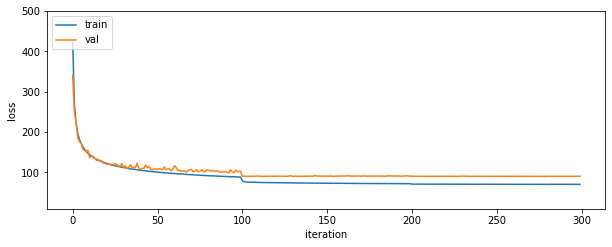

In [12]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(10,500)

In [13]:
#test model- IMPORTANT TO USE NEVER BEFORE SEEN DATA

#from train data (not ideal to use for testing)
# prediction = model.predict(x_train[-1000:-1])
# actual = y_train[-1000:-1]

#x_data
trajTest = np.loadtxt(open("simulation/data/traj1k.txt", "rb"), delimiter=",")
trajPtsTest = np.shape(trajTest)[0] #points per test trajectory
numTrajTest = np.shape(trajTest)[1]//3 #number of test trajectories
tTest = np.zeros([trajPtsTest,3,numTrajTest])
for j in range(np.shape(trajTest)[0]):
    for i in range(np.shape(trajTest)[1]//3):
        tTest[j,:,i] = trajTest[j,3*i:3*(i+1)]
#swap axis so batch size is first axis (for TF)
tTest = np.swapaxes(tTest,0,2)
#swap axis again so that conv1D moves on time and not xyz
tTest = np.swapaxes(tTest,1,2)
x_test = tf.convert_to_tensor(tTest,np.float32)

#y_data
jointPosTest = np.loadtxt(open("simulation/data/jointPos1k.txt", "rb"), delimiter=",")
y_test = tf.convert_to_tensor(jointPosTest,np.float32)

prediction = model.predict(x_test)
error = (y_test - prediction)
# print(np.floor(error))

#average error for estimates for each joint
avg = np.average(abs(error),axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130]
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*1000)/1000) #1 is full range of joint
print("total error = ",sum(rel_error))
#current best is: 
#                 0.460 @ [0.092 0.082 0.036 0.092 0.064 0.026 0.065]
#                 val_error: 90.46

# print(prediction[-10])
# print(y_test[-10])

average error =  [ 4.6392007  4.9545536  2.4391654 10.214085   7.704418   9.492755
  8.46071  ]
error as frac of joint range =  [0.092 0.082 0.036 0.092 0.064 0.026 0.065]
total error =  0.46000563483076434


In [14]:
model.save("trajectory_cls.kmod")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: trajectory_cls.kmod\assets


In [ ]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([1000,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (actual - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

rel_fake_error = fake_avg/ranges

print("error as frac of joint range: ",rel_fake_error)
print("total error: ", sum(rel_fake_error))

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint